<a href="https://colab.research.google.com/github/deexth/Pyt/blob/master/chpt2_hml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import the libraries/dependencies

In [1]:
!pip install pandas matplotlib numpy pathlib
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 15.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [2]:
import pandas as pd
import numpy as np
import pathlib
from zlib import crc32
import matplotlib.pyplot as plt
import tarfile
import urllib.request
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit


%matplotlib inline

# Get the data

*We are going to predict the median house value of in the californian district*

## Download the data

In [24]:
def load_housing_data(url):
    tarball_path = pathlib.Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        pathlib.Path("datasets").mkdir(parents=True, exist_ok=True)
        url = url
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(pathlib.Path("datasets/housing/housing.csv"))

url = "https://github.com/ageron/data/raw/main/housing.tgz"
housing = load_housing_data(url)


## Take a quick look at the data structure

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing['median_income'].max()

15.0001

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing[["ocean_proximity"]].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [9]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300) -> None:
    path = pathlib.Path("Images/end_to_end_project")
    if not path.is_dir():
        path.mkdir(parents=True, exist_ok=True)

    path_with_file = path / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path_with_file, format=fig_extension, dpi=resolution)
    print(f"Saving figure {fig_id}")

Saving figure attribute_histogram_plots


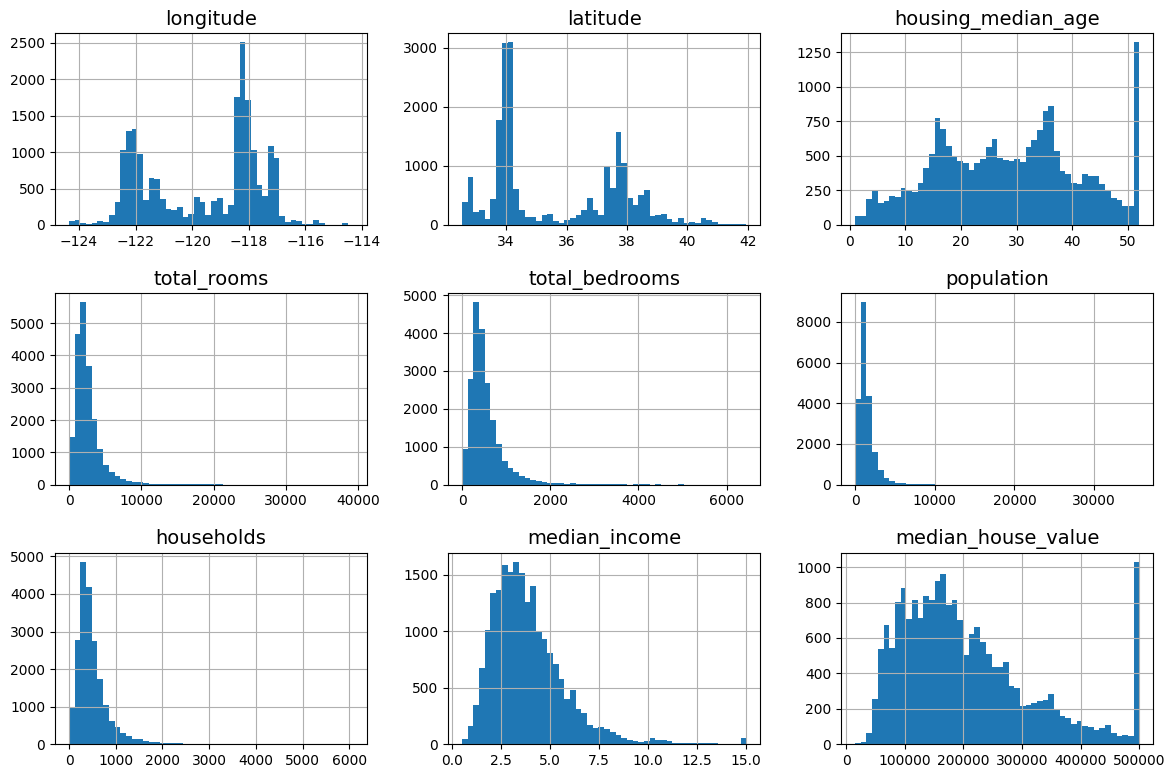

In [10]:
# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12,8))
save_fig("attribute_histogram_plots")
plt.show()

# Create a test

In [11]:
housing["median_income"].min()

0.4999

In [12]:
def shuffle_and_split(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[test_indices], data.iloc[train_indices]


test_set, train_set = shuffle_and_split(housing, 0.2)
len(test_set), len(train_set)

(4128, 16512)

*To always get the same data in the future or when there's new data we can set a random seed **np.random.seed(42)**, or we can use a hash to add 20% of values less than the has value to the test set and the rest to the train st*

In [13]:
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier).tobytes()) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")
len(test_set), len(train_set)

(4128, 16512)

In [14]:
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [15]:
housing['median_income'].value_counts()


,count
median_income,
3.1250,49
15.0001,49
2.8750,46
4.1250,44
2.6250,44
...,...
4.2670,1
2.1217,1
4.9706,1


*We can try using the longitude and latitude as the identifiers since they are bound to not change anyttime soon, and it prevents some data being mixed up in case new data is not appended at the end or an ID is deleted.*

In [16]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")
len(test_set), len(train_set)

(4318, 16322)

In [17]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
len(test_set), len(train_set)

(4128, 16512)

### Stratified sampling

*Dividing the median income into categories labeled 1 to 5 where 1 is ranges of 0-1.5, so less than $15k amount income*

Saving figure income_cat_bar_plot


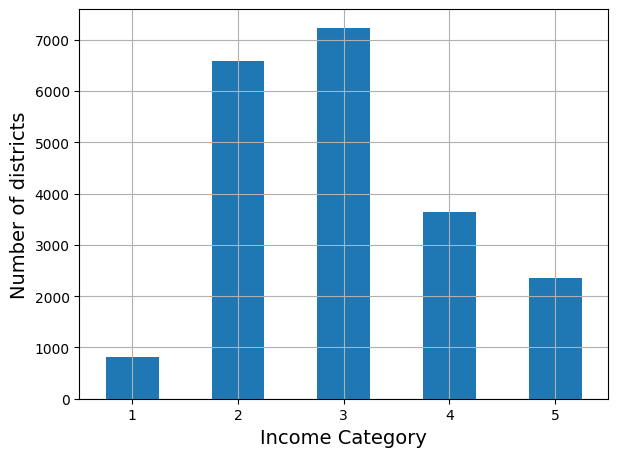

In [18]:
housing["income_cat"] = pd.cut(housing['median_income'], bins=[0, 1.5, 3, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
save_fig("income_cat_bar_plot")
plt.show()


*Using sk-learn for stratified sampling*

In [19]:
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set = housing.iloc[train_index]
    strat_test_set = housing.iloc[test_index]
    strat_splits.append([strat_train_set, strat_test_set])

strat_train_set, strat_test_set = strat_splits[0]


*If we wanted a single split with stratified sampling we can use the train_test_split function and pass is stratified*

In [20]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

*check the income category proportions in the test set*

In [21]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


*Compare the data generated using stratified sampling and randomness*

In [22]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_df = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()

compare_df.index.name = "Income Category"

compare_df["strat error %"] = compare_df["Stratified %"] / compare_df["Overall %"] - 1
compare_df["random error %"] = compare_df["Random %"] / compare_df["Overall %"] - 1
(100 * compare_df).round(2)

,Overall %,Stratified %,Random %,strat error %,random error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


*Since we no longer need the income_cat column we can drop it*

In [23]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Explore and visualize the data to get insights

### *Function to get images*

In [34]:
def get_image(url, filename, extension="png"):
    path = pathlib.Path("Images/")
    if not path.is_dir():
        path.mkdir(parents=True, exist_ok=True)

    full_path = path / f"{filename}.{extension}"
    urllib.request.urlretrieve(url, full_path)
    return full_path


### *Make a copy of the training set before making the exploration*

In [35]:
housing = strat_train_set.copy()

## Visualizing geographical data

Saving figure bad_visualization_plot


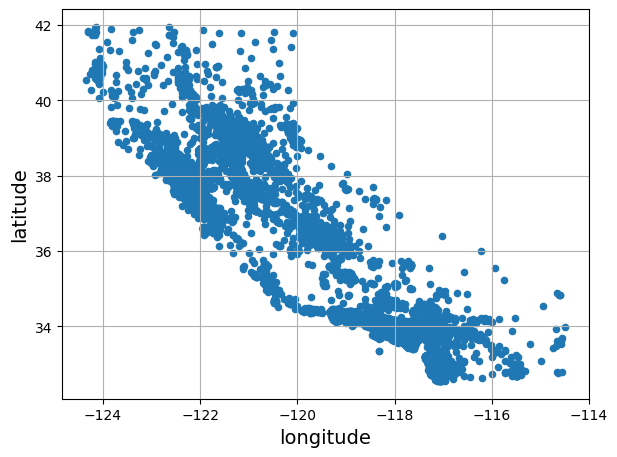

In [38]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot")
plt.show()

*Use alpha to have a better visualization*

Saving figure better_visualization_plot


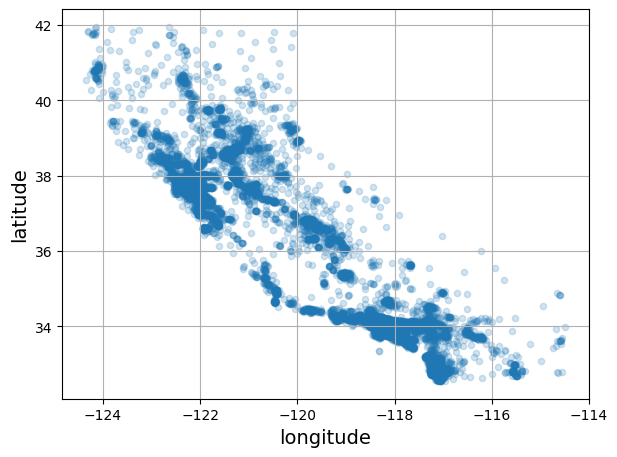

In [40]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, grid=True)
plt.show()

*Add heatmap to the plot*

Saving figure housing_prices_scatter_plot


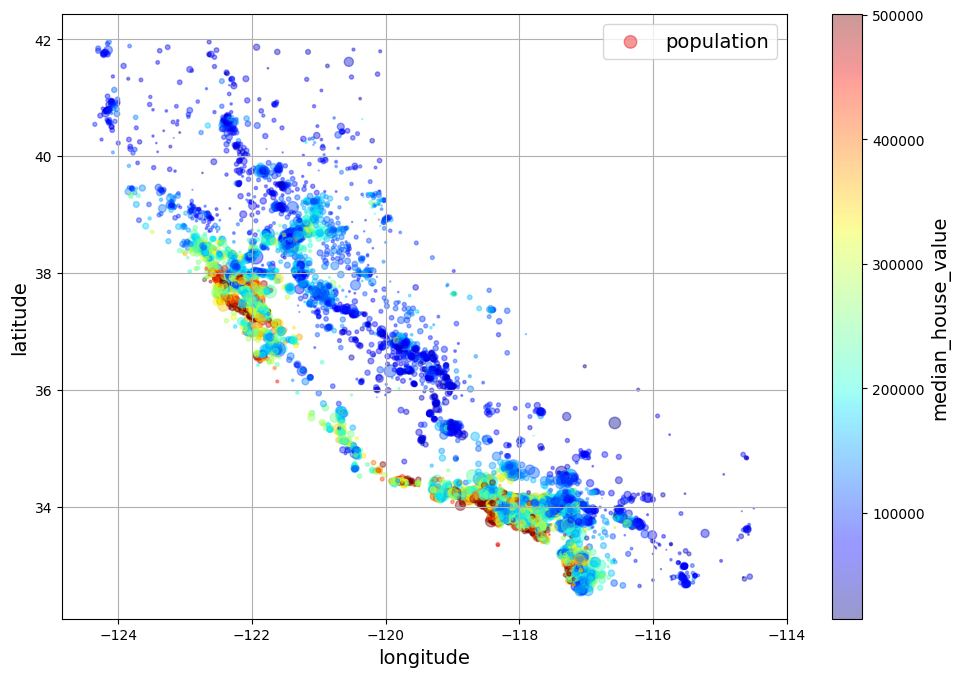

In [43]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population", figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, grid=True, legend=True, sharex=False)
save_fig("housing_prices_scatter_plot")
plt.show()

*Plot over the california map*

Saving figure california_housing_prices_plot


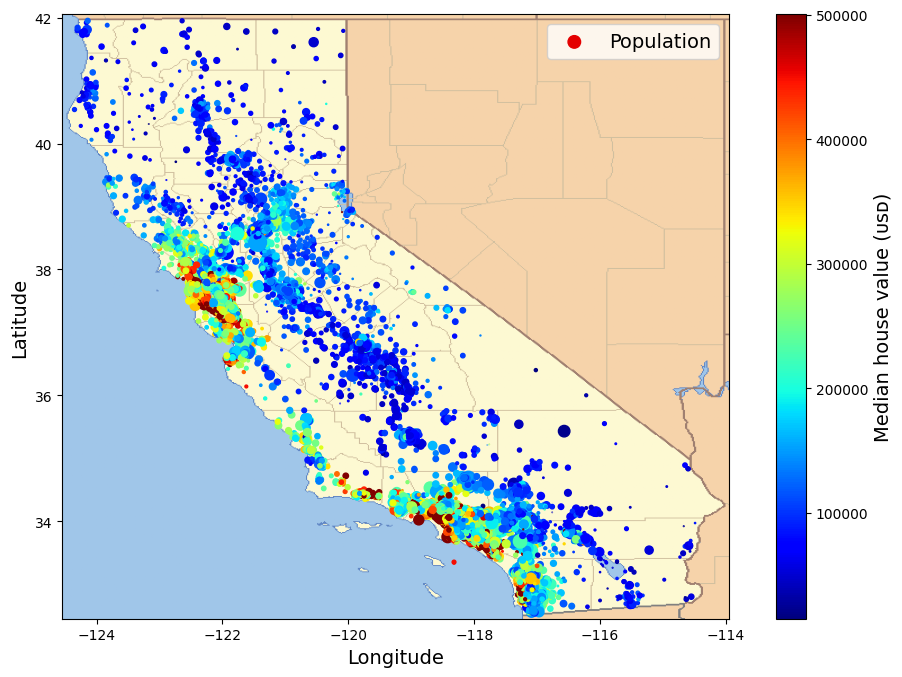

In [44]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

path = pathlib.Path("Images/california.png")
california_img = plt.imread(path)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()

### Look for correlations